In [1]:
# Some Preliminary imports and so on
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Exploring simulated model atmospheres and their synthetic spectra

### In this jupyter notebook we will:
- Familiarize ourselves with a simulated 3D model of the solar photosphere, obtained with MURaM code (Rempel 2014)
- Familiarize ourselves with the synthetic spectrum of two iron spectral lines around 630 nm, calculated from this cube 
- Explore the relationship between the cube and the spectrum
- Prepare the data for the training in the simple DNN we will use later

The cube can be downloaded here:

https://drive.google.com/drive/folders/12S8h_zv2z8BwMg83JLVk04O9ke6Jy8bT?usp=sharing

## Simulation of the solar photosphere:

### What we have here:

A 4-D structure encoding 3D variation of different physical quantities in a path of the solar photosphere. 
Dimensions are as follows: 
- Parameter : 11 diferent physical parameters, we will only care about the temperature and velocity to begin with 
- Depth: 71 discrete depth points in the optical depth scale (recall the lecture)
- NX: 768 horizontal points, 16 km spacing 
- NY: 768 horizontal points alon different axis, 16 km spacing

In [2]:
# Open the atmos file and grab the data

stokes = fits.open("gris_20160824_009/l1_data/cube.fits")[0].data
stokes.shape

(250, 477, 4, 1010)

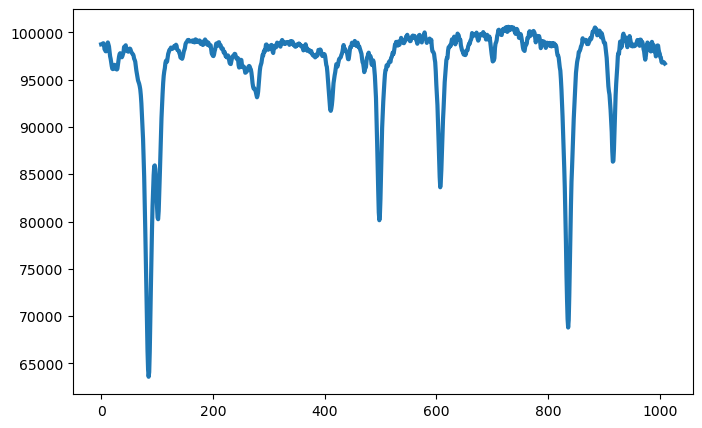

In [4]:
# Find the mean spectrum
mean_spectrum = np.mean(stokes, axis=(0,1))

plt.figure(figsize=[8,5])
plt.plot(mean_spectrum[0], linewidth=3)
#plt.xlim([5,30])

In [9]:
stokes.shape

(250, 477, 4, 1010)

In [11]:
qs = np.amax(mean_spectrum)
print(qs)

100590.30891404612


In [12]:
stokes = stokes/qs

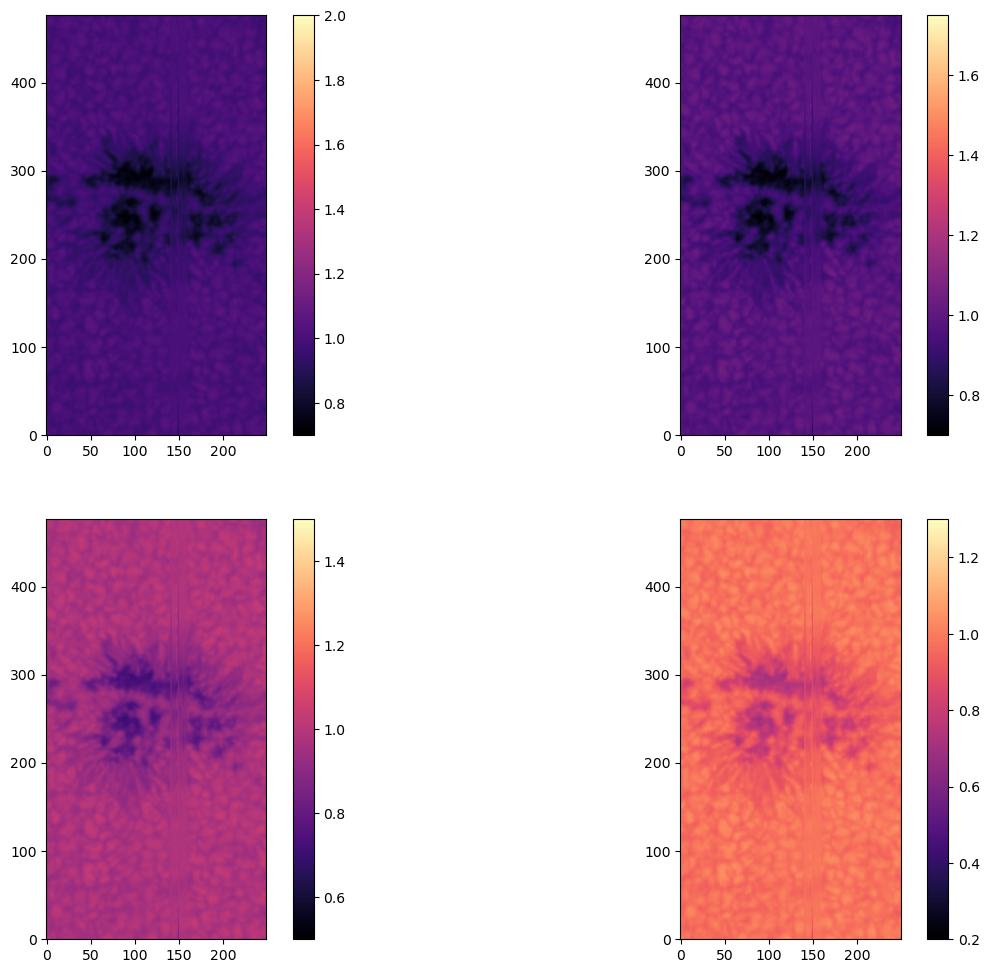

In [13]:
plt.figure(figsize=[15,12])
plt.subplot(221)
plt.imshow(stokes[:,:,0,10].T,cmap='magma',origin='lower',vmin=0.7,vmax=2.0)
plt.colorbar()
plt.subplot(222)
plt.imshow(stokes[:,:,0,23].T,cmap='magma',origin='lower',vmin=0.7,vmax=1.75)
plt.colorbar()
plt.subplot(223)
plt.imshow(stokes[:,:,0,26].T,cmap='magma',origin='lower',vmin=0.5,vmax=1.5)
plt.colorbar()
plt.subplot(224)
plt.imshow(stokes[:,:,0,29].T,cmap='magma',origin='lower',vmin=0.2,vmax=1.3)
plt.colorbar()

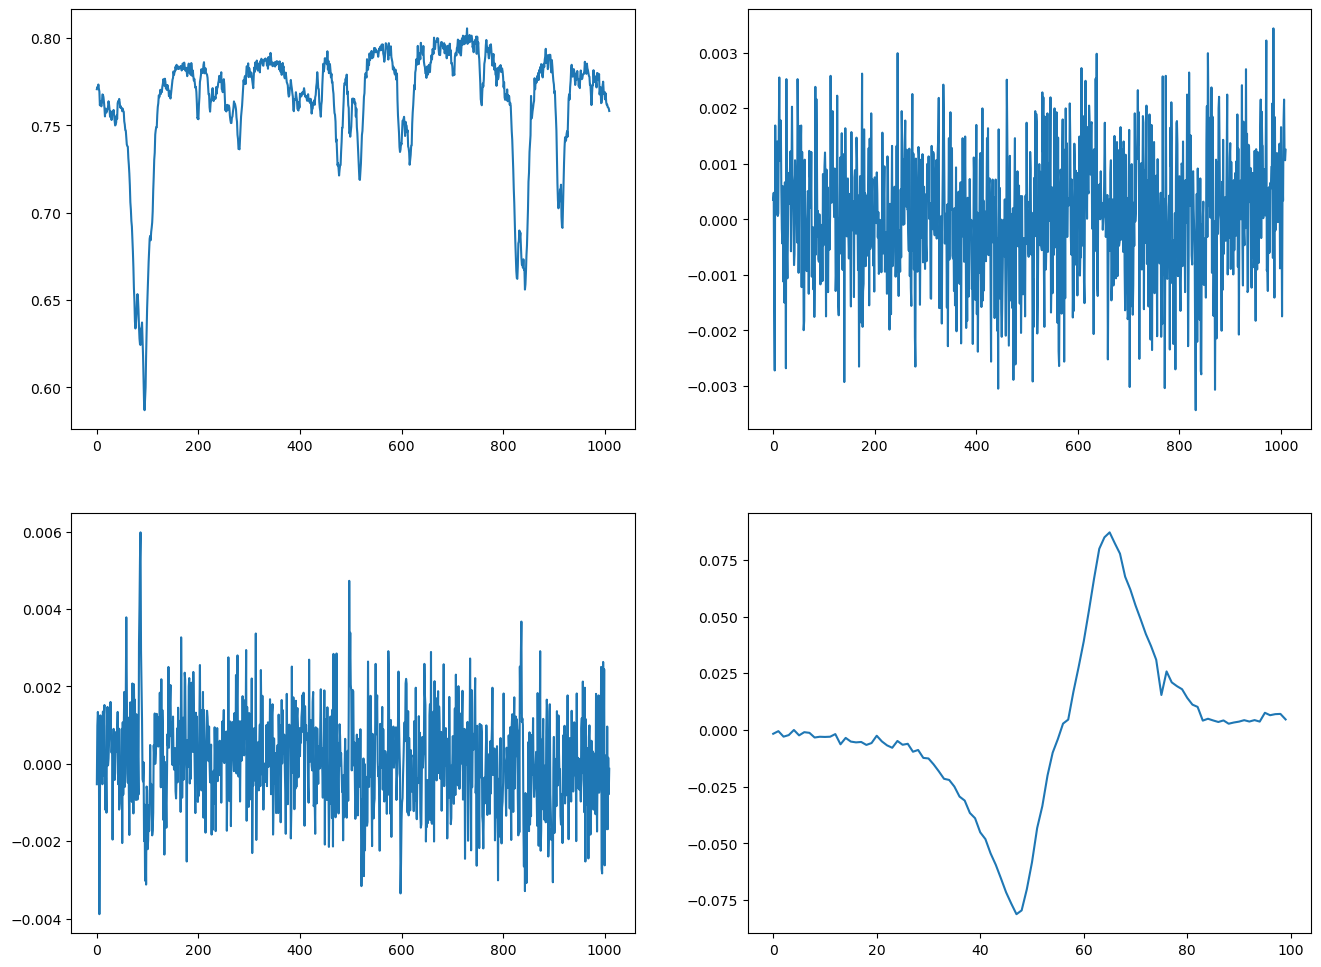

In [19]:
plt.figure(figsize=[16,12])
i = 100
j = 250

plt.subplot(221)
plt.plot(stokes[i,j,0])

plt.subplot(222)
plt.plot(stokes[i,j,1])

plt.subplot(223)
plt.plot(stokes[i,j,2])

plt.subplot(224)
plt.plot(stokes[i,j,3,780:880])


In [20]:
# Cut the data for the training: 

training = stokes[:,:,:,780:880]
training.shape

(250, 477, 4, 100)

In [20]:
# Mind the transpose thingy, fix this...

# Preparing the data for the NN training

### We are now going to do something fairly straightforward and technical. Normalize the spectra (input) and the temperature and velocity at few fixed heights (output), to the range 0,1 and write it to separate .fits files, so that we can train a network .

### With the little bit more advanced neural network architectures (that you probably know better than me), you can probably automatize this. 

### Also, batch normalization should (I think) get rid of many of these things for you automatically

In [21]:
### We will also make sure we save the normalizing quantities to the fits file so that we transform the outputs to the meaningful physical quantities.
### Very simple: 

In [38]:
#spectrum_max = np.amax(stokes[:,:,0,:])
#spectrum_min = np.amin(stokes[:,:,0,:])

#spectrum_norm = (stokes[:,:,0,:] - spectrum_min) / (spectrum_max - spectrum_min)

#spectrum_norm = spectrum_norm.reshape(-1,len(spectrum_norm[0,0]))

In [23]:
training_scaled = training[:,:,0:4,:] * 10.0
training_scaled[:,:,0,:] /= 10.0
mean = np.mean(training_scaled)
std = np.std(training_scaled)
print(mean,std)

0.23516789601873458 0.4159996375221421


In [24]:
training_norm = (training_scaled - mean) / std

In [25]:
training_norm = training_norm.astype("float32")

In [26]:
datahdu = fits.PrimaryHDU(training_norm)
normhdu = fits.ImageHDU([mean, std])

In [27]:
hdulist = fits.HDUList([datahdu, normhdu])
hdulist.writeto("normalized_data_in.fits",overwrite=True)

In [30]:
# Now the inversion results 

inv_data = fits.open("gris_20160824_009/inversion/gris_20160824_009_inversion.fits")

In [55]:
vlos = fits.open("gris_20160824_009/inversion/gris_20160824_009_inversion.fits")[1].data[0]
B = fits.open("gris_20160824_009/inversion/gris_20160824_009_inversion.fits")[2].data[0]
inc = fits.open("gris_20160824_009/inversion/gris_20160824_009_inversion.fits")[3].data[0]
azi = fits.open("gris_20160824_009/inversion/gris_20160824_009_inversion.fits")[4].data[0]

In [56]:
v_mean = np.mean(vlos[:,:100])
print (v_mean)
vlos -= v_mean

-343454.0589131289


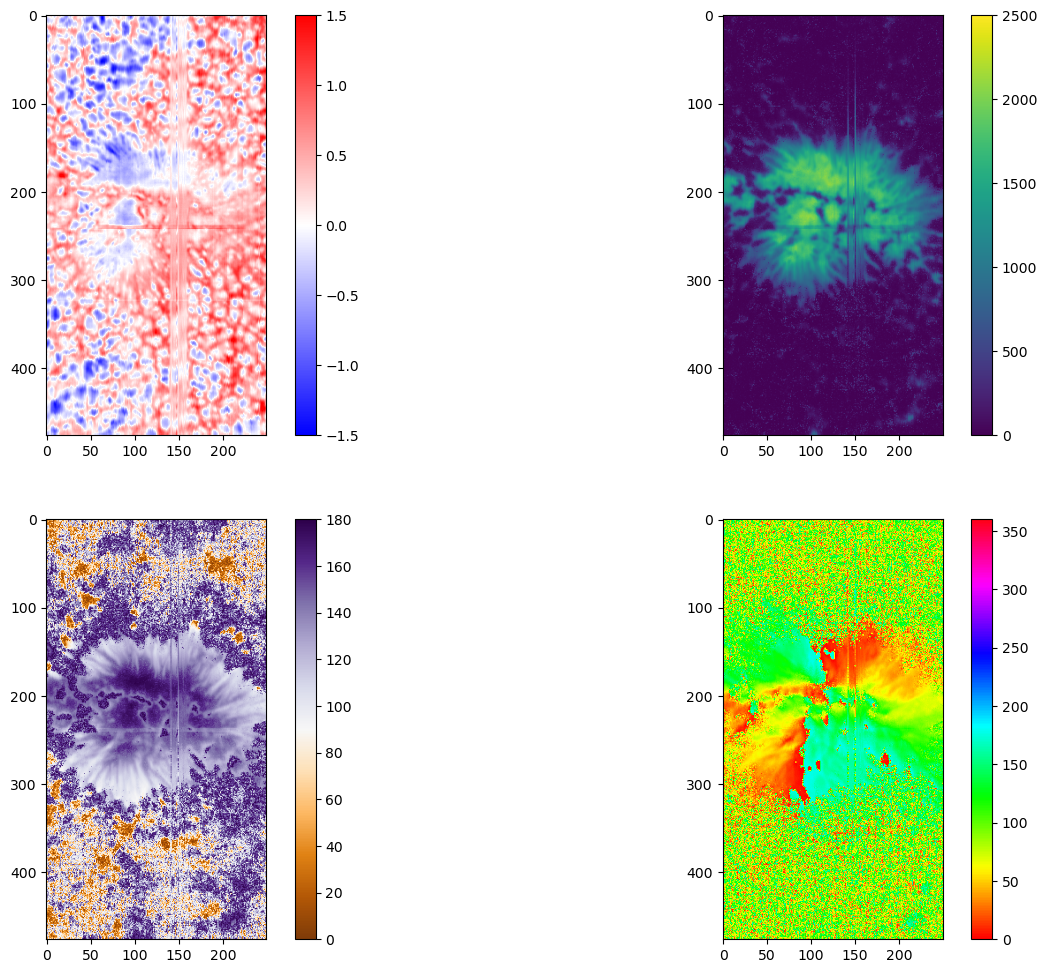

In [57]:
plt.figure(figsize=[16,12])
i = 100
j = 250

plt.subplot(221)
plt.imshow(vlos/1e5,cmap='bwr',vmin=-1.5,vmax=1.5)
plt.colorbar()

plt.subplot(222)
plt.imshow(B,vmax=2500)
plt.colorbar()

plt.subplot(223)
plt.imshow(inc,cmap='PuOr',vmin=0,vmax=180)
plt.colorbar()

plt.subplot(224)
plt.imshow(azi,cmap='hsv',vmin=0,vmax=360)
plt.colorbar()

In [58]:
v_mean = np.mean(vlos)
v_std = np.std(vlos)
B_mean = np.mean(B)
B_std = np.std(B)
mu = np.cos(np.radians(inc))
cos2p = np.cos(2.0*np.radians(azi))
sin2p = np.sin(2.0*np.radians(azi))

In [59]:
vlos = (vlos-v_mean) / v_std
B = (B-B_mean) / B_std

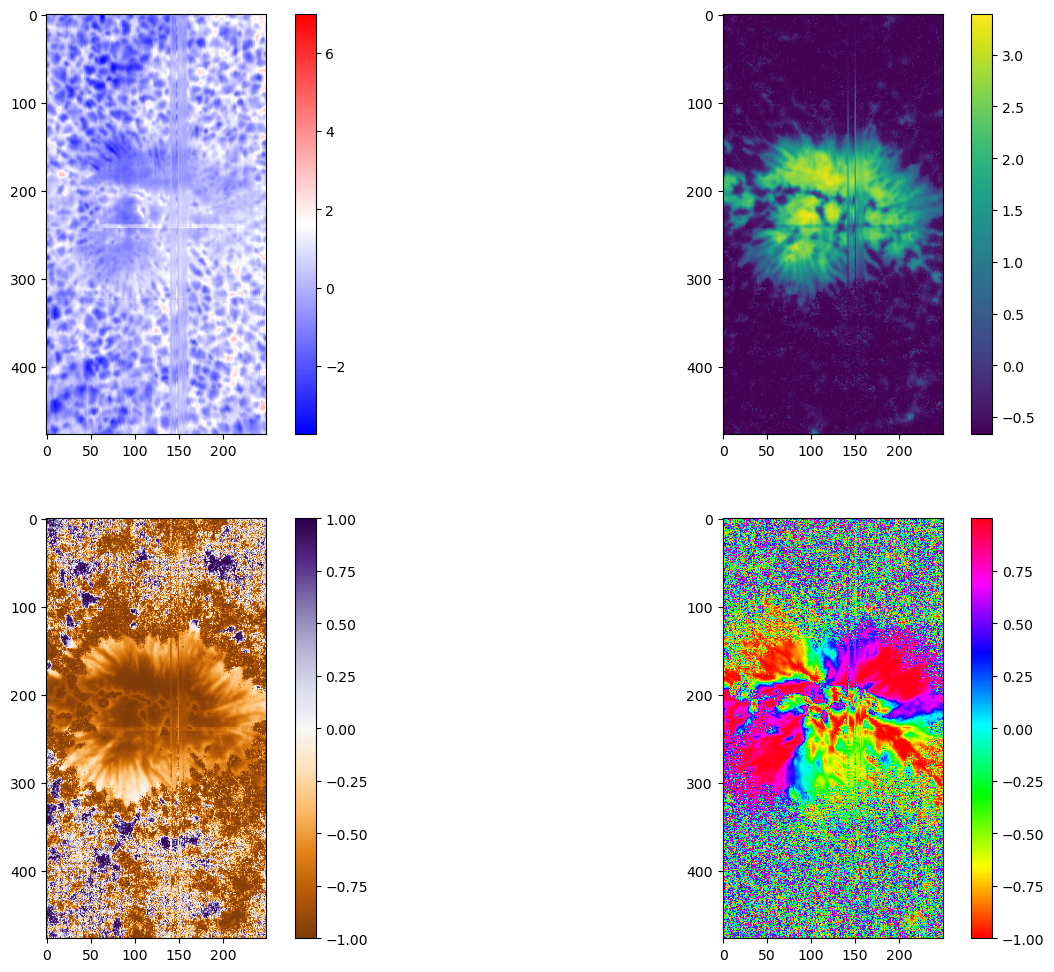

In [61]:
plt.figure(figsize=[16,12])
i = 100
j = 250

plt.subplot(221)
plt.imshow(vlos,cmap='bwr')
plt.colorbar()

plt.subplot(222)
plt.imshow(B)
plt.colorbar()

plt.subplot(223)
plt.imshow(mu,cmap='PuOr')
plt.colorbar()

plt.subplot(224)
plt.imshow(sin2p,cmap='hsv')
plt.colorbar()

In [64]:
hdu1 = fits.PrimaryHDU(vlos)
hdu2 = fits.ImageHDU(B)
hdu3 = fits.ImageHDU(mu)
hdu4 = fits.ImageHDU(cos2p)
hdu5 = fits.ImageHDU(sin2p)
hdu6 = fits.ImageHDU([v_mean, v_std])
hdu7 = fits.ImageHDU([B_mean, B_std])

In [65]:
hdulist = fits.HDUList([hdu1, hdu2, hdu3, hdu4, hdu5, hdu6, hdu7])
hdulist.writeto("normalized_data_out.fits",overwrite=True)

## Time to go to training! -> Lunch